In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from numba import jit
%load_ext Cython
% matplotlib inline

In [34]:
#get density profiles

#initial conditions 
nR=200
minR = 100 #in pc
maxR = 2000
smoothL = 0.01
dt=1e5 #in yrs
tStop=5e6 #in yrs
M=1e9 #in Msun
m=0.9*M #in Msun
G=4.96e-15 #in pc3 Msun-1 yr-2 (hopefully) 


addAnalytic=0 #include analytic soln
calcAnalytic=0 #recalculate analytic solution
if (addAnalytic==1 and calcAnalytic==1): #include analytic soln
    mu=(2-(M/m))**-1
    eps=1-(mu**-1)
    turn=findTurns(100000) #slooooow

nTimeStep=8
dTimeStep=int(tStop/(dt*(nTimeStep+1)))
timeSteps=np.arange(dTimeStep,(nTimeStep+1)*dTimeStep,dTimeStep)

#lists of density functions at given timesteps
point=[]
low=[]
mid=[]
high=[]

nAnalyticR=100
if (addAnalytic==1 and calcAnalytic==1):
    analytic=np.zeros((nTimeStep,nAnalyticR))
    analyticRs=np.zeros((nTimeStep,nAnalyticR))
if (addAnalytic==1 and calcAnalytic==1):
    for step in np.arange(0,nTimeStep):
        analytic[step,:],analyticRs[step,:]=getAnalyticDens(nAnalyticR,minR,maxR,timeSteps[step])

pointR,pointM=getRads(1,minR,maxR,nR,tStop,dt,0)
#lowR,lowM=getRads(0.3,minR,maxR,nR,tStop,dt,1)
midR,midM=getRads(1,minR,maxR,nR,tStop,dt,1)
#highR,highM=getRads(3,minR,maxR,nR,tStop,dt,1)

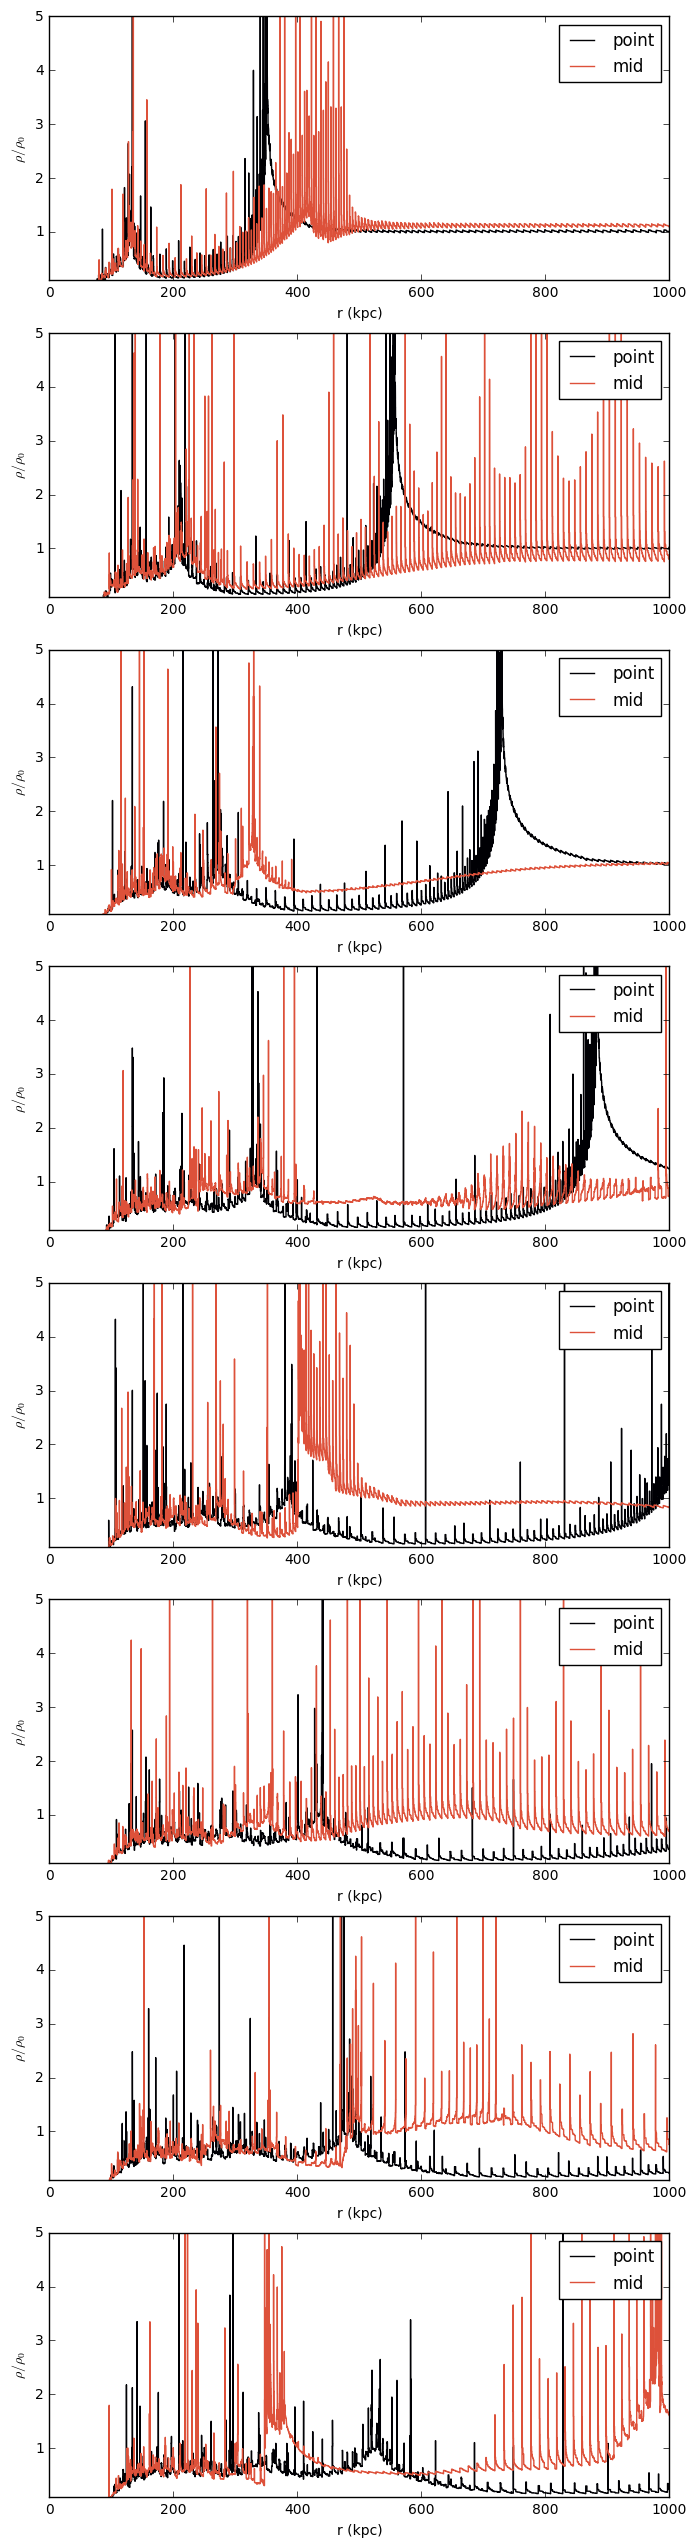

In [35]:
#plot density profiles
from matplotlib import gridspec

fig=plt.figure(figsize=(8,32))
grid=gridspec.GridSpec(8,1)
cmap = matplotlib.cm.get_cmap('inferno')

plotRads=np.linspace(minR,maxR,2000)

for step in range(nTimeStep):
    if (addAnalytic==1):
        getAnalyticPlot(analyticRs[step,:],analytic[step,:],'analytic','blue',0,step)
    getPlot(pointR[timeSteps[step],:],pointM,'point',0,0,step)
    #getPlot(lowR[timeSteps[step],:],lowM,'low',0.4,0,step)
    getPlot(midR[timeSteps[step],:],midM,'mid',0.6,0,step)
    #getPlot(highR[timeSteps[step],:],highM,'high',0.8,0,step)

In [34]:
fig.savefig("iForgotToRenameTheFile.png")
plt.close()

In [31]:
#utilities
@jit
def getInits(Rho,minR,maxR,nShells,nPhase): #creates an array of initial radii and the masses of shells for a given density
    shellR=np.zeros(nShells*nPhase)
    shellM=np.zeros(nShells*nPhase)
    shellVr=np.zeros(nShells*nPhase)
    rs=np.linspace(np.sqrt(minR),np.sqrt(maxR),nShells)**2 #in pc
    ms=(1/nPhase)*(4/3)*np.pi*Rho*((rs[1:]**3)-(rs[:-1]**3))
    for i in range(nShells):
        shellR[i*nPhase:(i+1)*nPhase]=rs[i]
        shellM[i*nPhase:(i+1)*nPhase]=ms[i]
        shellVr[i*nPhase:(i+1)*nPhase]=(np.arange(nPhase)/(nPhase-1))-1/2 #to be multiplied by circular velocity
    return shellR,shellM,shellVr

def runSim(shellR,shellM,shellVr,tStop,dt,scCheck): #runs simulation for a given density, with or without self consistancy
    nR=shellR.size
    m0=findMass(shellR,shellM,scCheck) #mass AFTER mass loss
    lSq=G*(m0+M-m)*shellR #(m0+M-m) is mass internal BEFORE mass loss

    rad=np.zeros((int(tStop/dt),nR)) #radius of each shell boundary at each timestep
    rad[0,:]=shellR
    mass=np.zeros((int(tStop/dt),nR)) #mass internal to each shell boundary at each timestep
    mass[0,:]=m0
    vel=np.zeros((int(tStop/dt),nR))
    vel[0,:]=0.1*shellVr*np.sqrt(lSq)/shellR #radial velocity of each shell boundary
    
    findMassT=0
    for step in np.arange(1,int(tStop/dt)):
        rad[step,:]=rad[step-1,:]+dt*vel[step-1,:]
        mass[step,:]=findMass(rad[step,:],shellM,scCheck)
        acc=(rad[step,:]**-3)*(lSq[:]-G*mass[step-1,:]*rad[step,:])
        vel[step,:]=vel[step-1,:]+dt*acc
    return rad

@jit
def findMass(rads,shellM,scCheck): #finds mass within radii of each shell (by summing all other cells)
    nR=rads.size
    massInRad=m*np.ones(nR)
    if (scCheck==0):
        return massInRad
    for i in range(0,nR):
        thisRad=rads[i]
        innerMass=0
        inside,=np.where((rads[:-1]<=thisRad) & (rads[1:]<=thisRad)) #both shell bounds within r
        overLR,=np.where((rads[:-1]<thisRad) & (rads[1:]>thisRad)) #lower shell bound within r (returns index below r)
        overRL,=np.where((rads[:-1]>thisRad) & (rads[1:]<thisRad)) #upper shell bound within r (returns index above r)
        
        if (inside.size > 0):
            innerMass+=np.sum(shellM[inside])
        if (overLR.size > 0):
            for index in overLR:
                innerMass+=shellM[index]*(thisRad**3-rads[index]**3)/(rads[index+1]**3-rads[index]**3)
        if (overRL.size > 0):
            for index in overRL:
                innerMass+=shellM[index]*(thisRad**3-rads[index+1]**3)/(rads[index]**3-rads[index+1]**3)
        massInRad[i]+=innerMass
    return massInRad

def getRads(Rho,minR,maxR,nR,tStop,dt,scCheck): #runs simulation and returns the radii
    initR,initM,initVr=getInits(Rho,minR,maxR,nR,49)
    rads=runSim(initR,initM,initVr,tStop,dt,scCheck)
    return rads,initM

def getPlot(shellR,shellM,name,colour,iPlot,jPlot): #plots density profile from radii
    #densVal=dens(rads)
    dens=getDens(shellR,shellM)
    sortD=sortDens(shellR,dens)
    rads=sortD[2]
    densVal=sortD[3]
    densVal=densVal/1 #normalizing (hopefully finding undisturbed well-sampled region)
    ax=plt.subplot(grid[jPlot,iPlot])
    ax.plot(rads,densVal,color=cmap(colour),label=name) #seems to be offset between analytic soln and numerical hence shellBound
    ax.legend(loc='upper right')
    ax.set_xlim(0,1000)
    ax.set_ylim(0.1,5)
    ax.set_xlabel("r (kpc)")
    ax.set_ylabel(r"$\rho / \rho_0$")

def getDens(rads,shellM): #finds the denisty between each set of shells, returning the density BEYOND each shell, in original shell order
    nRad=rads.size
    dens=np.zeros(nRad)
    for i in np.arange(nRad-1):
        thisR=rads[i]
        nextR=rads[i+1]
        if (thisR<nextR):
            thisD=shellM[i]/((4/3)*np.pi*(nextR**3 - thisR**3))
            dens[i]+=thisD
            between,=np.where((rads>thisR) & (rads<nextR))
            if (between.size>0):
                dens[between]+=thisD
        if (thisR>nextR):
            thisD=shellM[i]/((4/3)*np.pi*(thisR**3 - nextR**3))
            dens[i+1]+=thisD
            between,=np.where((rads>nextR) & (rads<thisR))
            if (between.size>0):
                dens[between]+=thisD
    return dens

def sortDens(rads,dens): #takes radii and dens sorted by initial radii, resorts in current radii
    #also outputs "boxed" version for more accurate plotting
    #tries to get rid of erroneous values (at small radii where integrator breaks down)
    dropTill=0
    if (np.any(rads<0)):
        dropTill=np.max(np.arange(rads.size)[rads<0])
    #print("dropping ",dropTill," shells")
    rads=rads[2*dropTill:]
    dens=dens[2*dropTill:]
    sort=np.argsort(rads)
    sortR=rads[sort]
    sortD=dens[sort]
    nR=sort.size
    boxR=np.zeros(2*(nR-1))
    boxD=np.zeros(2*(nR-1))
    for i in range(nR-1):
        boxR[2*i]=sortR[i]
        boxR[2*i+1]=sortR[i+1]
        boxD[2*i:2*i+2]=sortD[i]
    return sortR,sortD,boxR,boxD

In [11]:
#analytic soln
def findRad(eta):
    return ((G*m*(t**2))*((1-eps*np.cos(eta))**3)/((eta-eps*np.sin(eta))**2))**(1/3)
def findR0(eta):
    return ((G*m*(t**2)/(mu**3))*((eta-eps*np.sin(eta))**-2))**(1/3)
def F(eta,R):
    return findRad(eta)-R
def theta(eta): #flipped compared to notebook!
    return 1-eps*np.cos(eta)
def omega(eta):
    return 1-eps*(np.cos(eta)+(3*np.sin(eta)/2)*((eta-eps*np.sin(eta))/(1-eps*np.cos(eta))))
def rho(R):
    return 0.01
def etaMax(R): #maximum possible (but not probable) value of eta for a given R
    return (G*m*(t**2)*((1+eps)**3)/(R**3))**(1/2)
def etaMin(R): #minimum possible (but not probable) value of eta for a given R
    return (G*m*(t**2)*((1-eps)**3)/(R**3))**(1/2)
def etaTurn(eta):
    return (3*eps*eta*np.sin(eta))+(4*eps*np.cos(eta))-2*(1+(eps**2))-(eps**2)*(np.sin(eta)**2)
def findTurns(n): #finds the eta corresponding to turning points in r(eta)
    turnPt=np.zeros(n+1)
    for i in range(1,n+1):
        lowerBound=(0.5+i)*np.pi
        upperBound=lowerBound+np.pi
        turnPt[i]=scipy.optimize.brentq(etaTurn,lowerBound,upperBound)
    return turnPt
def findInf(rMin,rMax): #finds the r0s between rMin and rMax corresponding to singularities in the density (omega(eta)=0) at time t
    lowEta=etaMin(rMax)
    #print("lower eta: ",lowEta)
    highEta=etaMax(rMin)
    #print("high eta: ",highEta)
    lowIndex=int((lowEta/np.pi)-1.5)
    if (lowIndex<0):
        lowIndex=0
    #print("lower index: ",lowIndex)
    highIndex=1+int((highEta/np.pi)-1.5)
    if (highIndex<1):
        return np.zeros(1)
    #print("high index: ",highIndex)
    nInf=highIndex-lowIndex
    rInf=np.zeros(nInf)
    for i in range(0,nInf):
        lowerBound=(1.5+i+lowIndex)*np.pi
        upperBound=lowerBound+np.pi
        etaInf=scipy.optimize.brentq(omega,lowerBound,upperBound)
        #print("root ",i," is ",etaInf)
        rInf[i]=findRad(etaInf)
    return rInf[((rInf>rMin) & (rInf<rMax))]
def genRads(rMin,rMax,nRads): #generates a list of radii irregularly spaced such as to be more dense around singularities (at a certain t)
    rads=np.linspace(np.sqrt(rMin),np.sqrt(rMax),nRads)**2
    rInf=findInf(rMin,rMax)
    nInf=rInf.size
    if (rInf[0]==0):
        return rads
    for i in range(0,nRads):
        #print("original rad: ",rads[i])
        near=np.argmin(np.abs(rads[i]-rInf))
        dist=rInf[near]-rads[i]
        #print(dist," from nearest point")
        #print("factor: ",np.exp(-(dist/(0.01*rads[i]))**2))
        rads[i]=rads[i]+dist*np.exp(-(dist/(0.01*rads[i]))**2)
        #print("new rad: ",rads[i])
    return rads
import scipy.optimize
def findEtas(R): #finds etas for which r(eta)=R
    value,lowInt = min((b,a) for a,b in enumerate(turn-etaMin(R)) if (b>0 and a%2==1))
    lowInt-=1
    if (findRad(turn[lowInt+1])-R>0):
        lowInt+=2
    value,highInt = min((b,a) for a,b in enumerate(turn-etaMax(R)) if (b>0 and a%2==0))
    highInt-=1
    if (R-findRad(turn[highInt-1])>0):
        highInt-=2
    nInt=highInt-lowInt
    etas=np.zeros(nInt)
    diff=0
    for i in range(0,nInt):
        if (i==0):
            if (findRad(turn[lowInt])<R):
                etas=etas[:-1]
                diff=-1
                continue
        if (i==nInt-1):
            if (findRad(turn[highInt])<R and findRad(turn[highInt-1])<R):
                etas=etas[:-1]
                break
        lowerBound=turn[lowInt+i+diff]
        upperBound=turn[lowInt+i+1+diff]
        etas[i+diff]=scipy.optimize.brentq(F,lowerBound,upperBound,args=(R))
    return etas
def findAnalyticDens(R): #finds the analytic density at one radii
    etas=findEtas(R)
    th_mu=(theta(etas)*mu)**-1
    dens=rho(R*th_mu)
    om_mu=(omega(etas)*mu)**-1
    return np.sum(dens*om_mu*(th_mu**2))
def getAnalyticDens(nRad,rMin,rMax,timeStep): #finds the analytic density profile (piecewise)
    global t
    t=timeStep*dt
    Rs=genRads(rMin,rMax,nRad)
    Rhos=np.zeros(len(Rs))
    for i in np.arange(0,len(Rs)):
        Rhos[i]=findAnalyticDens(Rs[i])
    Rhos=Rhos/Rhos[-1]
    return Rhos, Rs
def getAnalyticPlot(rads,dens,name,colourName,iPlot,jPlot): #plots precalculated density profile (piecewise)
    ax=plt.subplot(grid[jPlot,iPlot])
    ax.semilogy(rads,dens,color=colourName,label=name)
    ax.legend(loc='upper right')
    ax.set_xlim(0,1000)
    ax.set_ylim(0.1,5)
    ax.set_xlabel("r (kpc)")
    ax.set_ylabel(r"$\rho / \rho_0$")
def plotAnalyticDens(timeSteps): #finds analytic dens profile and plots (all in one)
    global t
    for j in range(timeSteps.size):
        t=timeSteps[j]*dt
        nRad=100
        Rs=genRads(initR[0],initR[-1],nRad)
        Rhos=np.zeros(len(Rs))
        for i in np.arange(0,len(Rs)):
            Rhos[i]=findAnalyticDens(Rs[i])
        Rhos=Rhos/Rhos[-1]
        ax=plt.subplot(grid[j,0])
        ax.semilogy(Rs,Rhos,color='blue',label='analytic')
        ax.legend(loc='upper right')
        ax.set_xlim(0,2000)
        ax.set_ylim(0.1,10)
        ax.set_xlabel("r (kpc)")
        ax.set_ylabel(r"$\rho / \rho_0$")

In [17]:
#not actually using anymore, effectively JUNK
from scipy.spatial.distance import cdist

class gaussian_kde(object):

    def __init__(self, dataset, bw_method=None, weights=None):
        self.dataset = np.atleast_2d(dataset)
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")
        self.d, self.n = self.dataset.shape
            
        if weights is not None:
            self.weights = weights / np.sum(weights)
        else:
            self.weights = np.ones(self.n) / self.n
            
        # Compute the effective sample size 
        # http://surveyanalysis.org/wiki/Design_Effects_and_Effective_Sample_Size#Kish.27s_approximate_formula_for_computing_effective_sample_size
        self.neff = 1.0 / np.sum(self.weights ** 2)

        self.set_bandwidth(bw_method=bw_method)

    def evaluate(self, points):
        points = np.atleast_2d(points)

        d, m = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = np.reshape(points, (self.d, 1))
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        # compute the normalised residuals
        chi2 = cdist(points.T, self.dataset.T, 'mahalanobis', VI=self.inv_cov) ** 2
        # compute the pdf
        result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor

        return result

    __call__ = evaluate

    def scotts_factor(self):
        return np.power(self.neff, -1./(self.d+4))

    def silverman_factor(self):
        return np.power(self.neff*(self.d+2.0)/4.0, -1./(self.d+4))

    #  Default method to calculate bandwidth, can be overwritten by subclass
    covariance_factor = scotts_factor

    def set_bandwidth(self, bw_method=None):

        if bw_method is None:
            pass
        elif bw_method == 'scott':
            self.covariance_factor = self.scotts_factor
        elif bw_method == 'silverman':
            self.covariance_factor = self.silverman_factor
        elif np.isscalar(bw_method) and not isinstance(bw_method, str):
            self._bw_method = 'use constant'
            self.covariance_factor = lambda: bw_method
        elif callable(bw_method):
            self._bw_method = bw_method
            self.covariance_factor = lambda: self._bw_method(self)
        else:
            msg = "`bw_method` should be 'scott', 'silverman', a scalar " \
                  "or a callable."
            raise ValueError(msg)

        self._compute_covariance()

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            # Compute the mean and residuals
            _mean = np.sum(self.weights * self.dataset, axis=1)
            _residual = (self.dataset - _mean[:, None])
            # Compute the biased covariance
            self._data_covariance = np.atleast_2d(np.dot(_residual * self.weights, _residual.T))
            # Correct for bias (http://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_covariance)
            self._data_covariance /= (1 - np.sum(self.weights ** 2))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n

step  0  with resolution:  100.0
has max dens:  102.021835004  at:  106.416302525
has integral:  3153625533.06
step  1  with resolution:  400.0
has max dens:  1358.6419481  at:  105.434694275
has integral:  5714289175.44
step  2  with resolution:  900.0
has max dens:  841.408536063  at:  105.421217487
has integral:  4802301748.7
step  3  with resolution:  1600.0
has max dens:  919122.527368  at:  67.6962849687
has integral:  138782224377.0
step  4  with resolution:  2500.0
has max dens:  1692.95387024  at:  107.537203468
has integral:  4838827700.41
step  5  with resolution:  3600.0
has max dens:  1448.46279126  at:  107.537087279
has integral:  4894441247.62
step  6  with resolution:  4900.0
has max dens:  4204.06910647  at:  107.5380361
has integral:  5164528770.9
step  7  with resolution:  6400.0
has max dens:  2471.64528403  at:  107.538012327
has integral:  4867906090.25
step  8  with resolution:  8100.0
has max dens:  9147.30239975  at:  74.0513674636
has integral:  5124102232.98

<function matplotlib.pyplot.show>

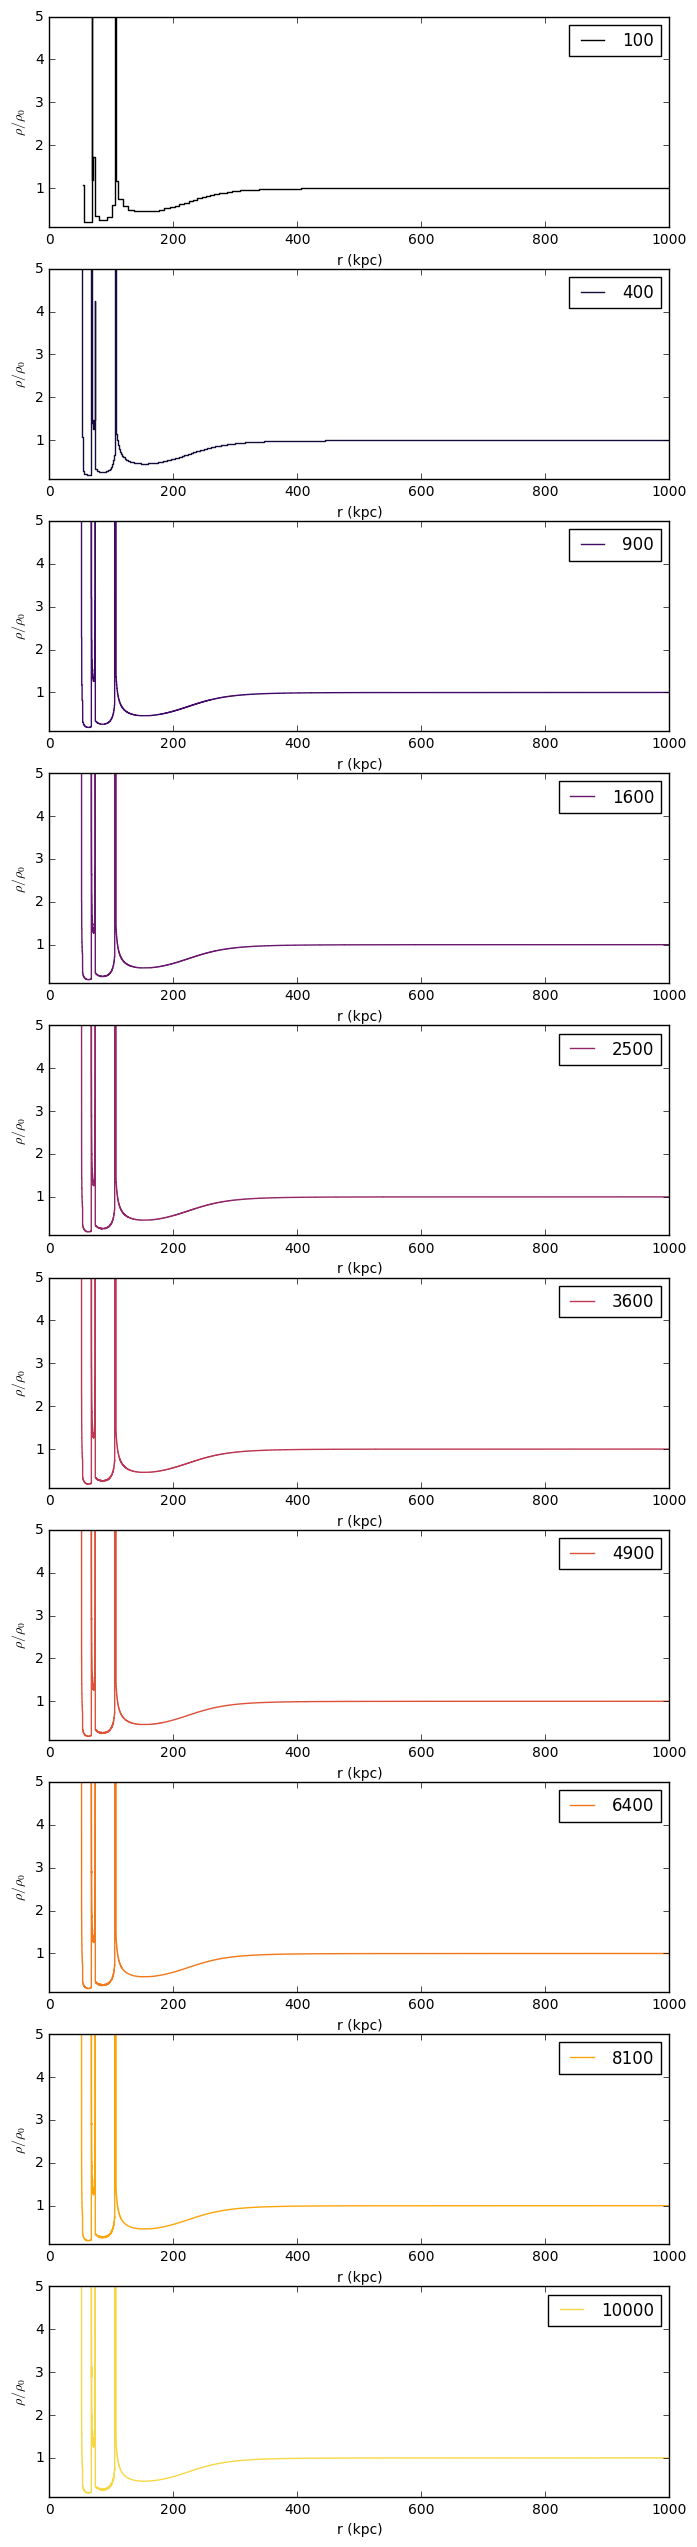

In [90]:
from scipy import integrate
#def intProfile(minR,maxR,nRads,deltaT,tMax): #runs simulation and calculates integral (probably messus up loads of other variables...)
#    smoothL=0.0002*maxR/np.sqrt(nRads)
#    dens=getDens(1,minR,maxR,nRads,smoothL,tMax,deltaT,1,-1)
#    #plotRads=np.linspace(minR,maxR,2000)
#    #plt.plot(plotRads,dens(plotRads),label=nRads)
#    #plt.legend()
#    def integrand(r):
#        return 4*np.pi*(r**2)*(dens(r)**2)
#    integral=integrate.quad(integrand, initR[0], initR[-1])
#    return integral[0]
def findInt(rads,shellM,minR,maxR): #finds the integral for a completed simulation
    def integrand(r):
        return 4*np.pi*(r**2)*findDens(rads,shellM,np.array([r]))
    integral=integrate.quad(integrand,minR,maxR)
    return integral[0]

def getInt(rads,dens,minR,maxR):
    sort=sortDens(rads,dens)
    sortR=sort[0]
    sortD=sort[1]
    low=np.argmin(sortR[(sortR>minR)])
    #print('low: ',low,' with radius: ',sortR[low])
    high=np.argmax(sortR[(sortR<maxR)])
    #print('high: ',high,' with rad: ',sortR[high])
    integral=0
    def integrand(r1,r2,D):
        return (4/3)*np.pi*((r2**3)-(r1**3))*(D**2)
    integral+=integrand(minR,sortR[low],sortD[low-1])
    integral+=integrand(sortR[high],maxR,sortD[high])
    for i in np.arange(low+1,high):
        integral+=integrand(sortR[i],sortR[i+1],sortD[i])
        #print("i: ",i," between: ",sortR[i]," and ",sortR[i+1])
        #print("with dens: ",sortD[i])
        #print("and int: ",integrand(sortR[i],sortR[i+1],dens[i]))
    return integral

#rads=pointR[timeSteps[7],:]
#dens=getDens(rads,pointM)
#minR=10
#maxR=2000
#print(getInt(rads,dens,minR,maxR)/((4/3)*0.1*np.pi*(maxR**3)))

fig=plt.figure(figsize=(8,32))
grid=gridspec.GridSpec(10,1)
cmap = matplotlib.cm.get_cmap('inferno')

res=np.linspace(10,100,10)**2
rhoSq=np.zeros(res.size)
rho0=10
minR=50
maxR=1000
dt=4e4 #in yrs
tStop=4e6 #in yrs
scCheck=1
for i in range(res.size):
    print("step ",i," with resolution: ",res[i])
    rads,shellM=getRads(rho0,minR,maxR,int(res[i]),tStop,dt,scCheck)
    getPlot(rads[-1,:],shellM,int(res[i]),i/res.size,0,i)
    dens=getDens(rads[-1,:],shellM)
    print("has max dens: ",np.max(dens)," at: ",rads[-1,np.argmax(dens)])
    #print("________radii: ",rads[-1,:])
    #print("dens: ",dens)
    rhoSq[i]=getInt(rads[-1,:],dens,10,200)
    print("has integral: ",rhoSq[i])
plt.show
#    testR=np.linspace(0.5,200,10000)
#    testDens=findDens(rads[timeSteps[0],:],shellM,testR)
#    rhoSq[i]=integrate.trapz(4*np.pi*(testR**2)*testDens,testR)/((4/3)*np.pi*(rho0)*(maxR**3))
    #rhoSq[i]=getInt(rads[timeSteps[0],:],shellM,minR,maxR)/((4/3)*np.pi*(rho0)*(maxR**3))
#    print("has integral: ",rhoSq[i])

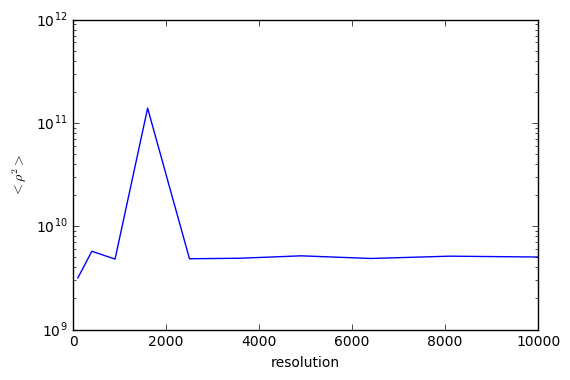

In [94]:
plt.semilogy(res,rhoSq)
plt.xlabel('resolution')
plt.ylabel(r'$<\rho^2>$')
#plt.savefig('resolutionStudy.png')
#plt.close

In [57]:
#older, worse test (than below). Probabaly JUNK
def vectorFindMass(rads,mass,scCheck):
    def addCase(M,case,whichCase):
        thisCase=np.where(case==whichCase)
        ns=thisCase[0]
        js=thisCase[1]
        if (whichCase==3): # case c, mass j contained with shell n
            mAdd=mass[js]
        if (whichCase==1): # case b, mass j split over shell n, with shell j+1 at or further than shell n
            mAdd=mass[js]*(rads[ns]**3-rads[js+1]**3)/(rads[js]**3-rads[js+1]**3)
        if (whichCase==-1): # case d, mass j split over shell n, with shell j at or further than shell n
            mAdd=mass[js]*(rads[ns]**3-rads[js]**3)/(rads[js+1]**3-rads[js]**3)
        # case a, mass j not contained within shell n, requires no action 
        np.add.at(M,ns,mAdd)
        return M

    nRads=rads.size
    M=m*np.ones(nRads)
    if (scCheck==0): #non self consistant - no self gravity
        return M
    s=np.argsort(np.argsort(rads))
    
    jDiff=np.tile(s,(nRads-1,1)).transpose() - np.tile(s[:-1],(nRads,1))
    jSign=np.sign(jDiff+0.1).astype(int)
    jPlusDiff=np.tile(s,(nRads-1,1)).transpose() - np.tile(s[1:],(nRads,1))
    jPlusSign=np.sign(jPlusDiff+0.1).astype(int)
    case=2*jPlusSign + jSign

    M=addCase(M,case,3) #case C
    M=addCase(M,case,1) #case B
    M=addCase(M,case,-1) #case D
    return M

nRads=2000    
rads=np.arange(nRads)**2
m=1
np.random.shuffle(rads)
mass=np.arange(nRads)**2
%prun MassEnclosed=findMass(rads,mass,1)
#%prun MEnc=oldFindMass(rads,mass,1)
#m=10
#r=np.array([1,3,2,4,5])
#masses=np.array([1,2,3,2])
#print(findMass(r,masses,1))

In [100]:
def findMass(rads,mass,scCheck):
    nRads=rads.size
    M=m*np.ones(nRads)
    if (scCheck==0): #non self consistant - no self gravity
        return M
    s=np.argsort(np.argsort(rads))
    
    jDiff=np.tile(s,(nRads-1,1)).transpose() - np.tile(s[:-1],(nRads,1))
    jSign=np.sign(jDiff+0.1).astype(int)
    jPlusDiff=np.tile(s,(nRads-1,1)).transpose() - np.tile(s[1:],(nRads,1))
    jPlusSign=np.sign(jPlusDiff+0.1).astype(int)
    case=2*jPlusSign + jSign

    for whichCase in np.arange(-1,5,2):
        thisCase=np.where(case==whichCase)
        ns=thisCase[0]
        js=thisCase[1]
        if (whichCase==3): # case c, mass j contained with shell n
            mAdd=mass[js]
        if (whichCase==1): # case b, mass j split over shell n, with shell j+1 at or further than shell n
            mAdd=mass[js]*(np.power(rads[ns],3)-np.power(rads[js+1],3))/(np.power(rads[js],3)-np.power(rads[js+1],3))
        if (whichCase==-1): # case d, mass j split over shell n, with shell j at or further than shell n
            mAdd=mass[js]*(np.power(rads[ns],3)-np.power(rads[js],3))/(np.power(rads[js+1],3)-np.power(rads[js],3))
        # case a, mass j not contained within shell n, requires no action 
        
        np.add.at(M,ns,mAdd)
    return M
#%prun MEnc=oldFindMass(rads,mass,1)
#m=10
#r=np.array([1,3,2,4,5])
#masses=np.array([1,2,3,2])
#print(findMass(r,masses,1))
nRads=500    
rads=1+np.power(np.arange(nRads),2.)/4000
vel=np.zeros(nRads)
np.random.shuffle(rads)
m=10
mass=1+np.arange(nRads)
lSq=mass*rads
nSteps=1000
times=np.arange(nSteps)
for step in range(nSteps):
    print('rad ',rads[0])
    print('vel ',vel[0])
    rads=rads+vel
    massEnclosed=findMass(rads,mass,1)
    acc=1000*(lSq-mass*rads)/np.power(rads,3)
    print('acc ',acc[0])
    vel=vel+acc
#%prun MassEnclosed=findMass(rads,mass,1)

rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.16225
vel  0.0
acc  0.0
rad  3.1

KeyboardInterrupt: 

In [32]:
#specifically testing findMass functions
@jit
def testFindMass(rads,shellM):
    nR=rads.size
    massInRad=5+np.zeros(nR)
    for i in range(0,nR):
        thisRad=rads[i]
        innerMass=0
        inside,=np.where((rads[:-1]<=thisRad) & (rads[1:]<=thisRad)) #both shell bounds within r
        overLR,=np.where((rads[:-1]<thisRad) & (rads[1:]>thisRad)) #lower shell bound within r (returns index below r)
        overRL,=np.where((rads[:-1]>thisRad) & (rads[1:]<thisRad)) #upper shell bound within r (returns index above r)

        if (inside.size > 0):
            innerMass+=np.sum(shellM[inside])
        if (overLR.size > 0):
            innerMass+=np.sum(shellM[overLR]*(thisRad**3-np.power(rads[overLR],3))/(np.power(rads[overLR+1],3)-np.power(rads[overLR],3)))
            #for index in overLR:
            #    innerMass+=shellM[index]*(thisRad**3-rads[index]**3)/(rads[index+1]**3-rads[index]**3)
        if (overRL.size > 0):
            innerMass+=np.sum(shellM[overRL]*(thisRad**3-np.power(rads[overRL+1],3))/(np.power(rads[overRL],3)-np.power(rads[overRL+1],3)))
            #for index in overRL:
            #    innerMass+=shellM[index]*(thisRad**3-rads[index+1]**3)/(rads[index]**3-rads[index+1]**3)
        massInRad[i]+=innerMass
    return massInRad

#all vectorized, much slower
def testAltFindMass(rads,mass):
    nRads=rads.size
    M=5+np.zeros(nRads)
    s=np.argsort(np.argsort(rads))

    jDiff=np.tile(s,(nRads-1,1)).transpose() - np.tile(s[:-1],(nRads,1))
    jSign=np.sign(jDiff+0.1).astype(int)
    jPlusDiff=np.tile(s,(nRads-1,1)).transpose() - np.tile(s[1:],(nRads,1))
    jPlusSign=np.sign(jPlusDiff+0.1).astype(int)
    case=2*jPlusSign + jSign

    for whichCase in np.arange(-1,5,2):
        thisCase=np.where(case==whichCase)
        ns=thisCase[0]
        js=thisCase[1]
        if (whichCase==3): # case c, mass j contained with shell n
            mAdd=mass[js]
        if (whichCase==1): # case b, mass j split over shell n, with shell j+1 at or further than shell n
            mAdd=mass[js]*(np.power(rads[ns],3)-np.power(rads[js+1],3))/(np.power(rads[js],3)-np.power(rads[js+1],3))
        if (whichCase==-1): # case d, mass j split over shell n, with shell j at or further than shell n
            mAdd=mass[js]*(np.power(rads[ns],3)-np.power(rads[js],3))/(np.power(rads[js+1],3)-np.power(rads[js],3))
        # case a, mass j not contained within shell n, requires no action 
        
        np.add.at(M,ns,mAdd)
    return M

def testRunSim(nRads,nSteps):
    rads=1+(np.arange(nRads)**2)/nRads
    vel=np.zeros(nRads)
    mass=1+np.arange(nRads)
    lSq=testFindMass(rads,mass)*rads+1
    for step in range(nSteps):
        rads=rads+vel
        massEnclosed=testFindMass(rads,mass)
        acc=0.001*(lSq-massEnclosed*rads)/np.power(rads,3)
        vel=vel+acc
        #print(rads[0])

%timeit testRunSim(500,500)

1 loop, best of 3: 775 ms per loop
